# [1] Считаем данные

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем данные
data = pd.read_csv('marketing_campaign.csv', sep='\t')

print(f"Размер датасета: {data.shape}")
print(f"Колонки: {data.columns.tolist()}")


Размер датасета: (2240, 29)
Колонки: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


# [2] У нас задача классификации

In [4]:
# -- Повторная информация о целевой переменной --
target = 'Response'
print(f"Целевая переменная: {target}")
print(f"Уникальные значения: {data[target].unique()}")
print(f"Количество уникальных значений: {data[target].nunique()}")
print(f"Распределение: {data[target].value_counts().to_dict()}")


Целевая переменная: Response
Уникальные значения: [1 0]
Количество уникальных значений: 2
Распределение: {0: 1906, 1: 334}


# [3] Предобработка данных

### A: Разделить выборку на тренировочную (train) и тестовую (test).

In [5]:
# --- 1. ОТДЕЛЯЕМ ПРИЗНАКИ И ЦЕЛЬ ---

# Целевая переменная
y = data['Response']

# Признаки (убираем целевой столбец и явные служебные поля)
X = data.drop(columns=['Response', 'ID', 'Z_CostContact', 'Z_Revenue'])

print("Форма X:", X.shape)
print("Форма y:", y.shape)


# ---  train/test  ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% в тест
    random_state=42,    # фиксируем для воспроизводимости
    stratify=y          # сохраняем пропорции классов 0/1
)

print("Train X:", X_train.shape)
print("Test  X:", X_test.shape)
print("Распределение классов в train:")
print(y_train.value_counts(normalize=True))
print("Распределение классов в test:")
print(y_test.value_counts(normalize=True))


Форма X: (2240, 25)
Форма y: (2240,)
Train X: (1792, 25)
Test  X: (448, 25)
Распределение классов в train:
Response
0    0.851004
1    0.148996
Name: proportion, dtype: float64
Распределение классов в test:
Response
0    0.850446
1    0.149554
Name: proportion, dtype: float64


### B: Проверить пропуски в данных

In [6]:
# ---  АНАЛИЗ ПРОПУСКОВ ---

print("Пропуски в train:")
print(X_train.isnull().sum())

print("\nПропуски в test:")
print(X_test.isnull().sum())

# Разделяем признаки по типам
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("\nЧисловые признаки:", num_cols)
print("Категориальные признаки:", cat_cols)

# --- ЗАПОЛНЕНИЕ ПРОПУСКОВ ---

# 1. Числовые: заполняем медианой по train
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='median')
num_imputer.fit(X_train[num_cols])          # считаем медианы только на train

X_train[num_cols] = num_imputer.transform(X_train[num_cols])
X_test[num_cols]  = num_imputer.transform(X_test[num_cols])

# 2. Категориальные заполняем модой (most_frequent)
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_imputer.fit(X_train[cat_cols])

X_train[cat_cols] = cat_imputer.transform(X_train[cat_cols])
X_test[cat_cols]  = cat_imputer.transform(X_test[cat_cols])

# Проверяем, что пропусков больше нет
print("\nПосле импутации, пропуски в train:")
print(X_train.isnull().sum())
print("\nПосле импутации, пропуски в test:")
print(X_test.isnull().sum())


Пропуски в train:
Year_Birth              0
Education               0
Marital_Status          0
Income                 21
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
dtype: int64

Пропуски в test:
Year_Birth             0
Education              0
Marital_Status         0
Income                 3
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
M

### C: Отнормировать численные переменные

In [7]:
from sklearn.preprocessing import StandardScaler

# создаём скейлер
scaler = StandardScaler()

# считаем параметры (среднее и std) ТОЛЬКО по train
scaler.fit(X_train[num_cols])

# применяем к train и test
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

X_train[num_cols].head()


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain
1090,0.342139,1.294130,-0.828060,-0.925853,0.444943,1.891312,-0.183717,3.021240,-0.229925,1.645925,...,0.659757,1.195745,0.383416,-1.361588,-0.283141,-0.281989,3.636237,-0.264293,-0.114025,-0.10352
15,-1.943388,1.177270,-0.828060,-0.925853,-0.895179,2.093752,-0.108461,-0.227785,0.387369,0.993932,...,1.012678,1.195745,1.923956,-0.955063,-0.283141,-0.281989,3.636237,3.783681,-0.114025,-0.10352
873,1.019333,-0.373888,1.026794,0.899370,-0.482834,-0.758265,-0.334230,-0.486635,-0.248081,-0.285907,...,-0.399005,-0.567565,-0.540909,0.671039,-0.283141,-0.281989,-0.275010,-0.264293,-0.114025,-0.10352
610,0.003543,-0.969628,-0.828060,-0.925853,0.857289,-0.600481,-0.334230,-0.401839,-0.320703,-0.213464,...,-0.399005,-0.567565,0.075308,0.264514,-0.283141,-0.281989,-0.275010,-0.264293,-0.114025,-0.10352
657,-0.927598,-0.984485,-0.828060,-0.925853,1.475807,-0.767196,0.518675,-0.508950,-0.302548,-0.165168,...,-0.399005,-0.567565,-0.232800,0.264514,-0.283141,-0.281989,-0.275010,-0.264293,-0.114025,-0.10352


### D: Закодировать категориальные признаки по одной из стратегий

In [8]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['Education', 'Marital_Status']  # Dt_Customer пока не трогаем

# ВАЖНО: используем sparse_output вместо sparse
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(X_train[cat_cols])

X_train_cat = ohe.transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])

ohe_feature_names = ohe.get_feature_names_out(cat_cols)

X_train_cat = pd.DataFrame(X_train_cat, columns=ohe_feature_names, index=X_train.index)
X_test_cat  = pd.DataFrame(X_test_cat,  columns=ohe_feature_names, index=X_test.index)

X_train_num = X_train.drop(columns=cat_cols + ['Dt_Customer'])
X_test_num  = X_test.drop(columns=cat_cols + ['Dt_Customer'])

X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final  = pd.concat([X_test_num,  X_test_cat],  axis=1)

X_train_final.head()


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
1090,0.342139,1.294130,-0.828060,-0.925853,0.444943,1.891312,-0.183717,3.021240,-0.229925,1.645925,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15,-1.943388,1.177270,-0.828060,-0.925853,-0.895179,2.093752,-0.108461,-0.227785,0.387369,0.993932,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
873,1.019333,-0.373888,1.026794,0.899370,-0.482834,-0.758265,-0.334230,-0.486635,-0.248081,-0.285907,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
610,0.003543,-0.969628,-0.828060,-0.925853,0.857289,-0.600481,-0.334230,-0.401839,-0.320703,-0.213464,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
657,-0.927598,-0.984485,-0.828060,-0.925853,1.475807,-0.767196,0.518675,-0.508950,-0.302548,-0.165168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# [4] Оформить данные в виде класса Dataset из библиотеки torch

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train_final.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values,       dtype=torch.long)

X_test_tensor  = torch.tensor(X_test_final.values,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values,        dtype=torch.long)

# 2. Класс Dataset для табличных данных
class MarketingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # тензор признаков
        self.y = y  # тензор целевых меток

    def __len__(self):
        return len(self.X)  # размер датасета

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # один объект (features, target)

# 3. Создаём объекты Dataset для train и test
train_dataset = MarketingDataset(X_train_tensor, y_train_tensor)
test_dataset  = MarketingDataset(X_test_tensor,  y_test_tensor)

# 4. Оборачиваем их в DataLoader
batch_size = 64  

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True  
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Быстрая проверка формы 
for xb, yb in train_loader:
    print("Batch X shape:", xb.shape)  # (batch_size, n_features)
    print("Batch y shape:", yb.shape)  # (batch_size,)
    break


Batch X shape: torch.Size([64, 35])
Batch y shape: torch.Size([64])


# [5] Обучить на тренировочном множестве

### A: Однослойную нейросеть с оптимизатором SGD

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Определяем простую однослойную сеть
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # скрытый слой
        self.act = nn.ReLU()                        # нелинейность
        self.fc2 = nn.Linear(hidden_dim, 1)         # выход (логит)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x  # логиты, сигмоиду применим в функции потерь

input_dim = X_train_final.shape[1]
model = SimpleNN(input_dim)

# 2. Функция потерь и оптимизатор SGD
criterion = nn.BCEWithLogitsLoss()          # бинарная классификация
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 3. Цикл обучения
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        # yb: shape (batch,), переводим в float и делаем колонку
        yb = yb.float().unsqueeze(1)

        # обнуляем градиенты
        optimizer.zero_grad()

        # прямой проход
        logits = model(xb)              # (batch, 1)

        # считаем loss
        loss = criterion(logits, yb)

        # обратное распространение
        loss.backward()

        # шаг оптимизатора
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {avg_loss:.4f}")


Epoch 1/20 | Train loss: 0.6327
Epoch 2/20 | Train loss: 0.5794
Epoch 3/20 | Train loss: 0.5387
Epoch 4/20 | Train loss: 0.5069
Epoch 5/20 | Train loss: 0.4816
Epoch 6/20 | Train loss: 0.4613
Epoch 7/20 | Train loss: 0.4447
Epoch 8/20 | Train loss: 0.4310
Epoch 9/20 | Train loss: 0.4196
Epoch 10/20 | Train loss: 0.4099
Epoch 11/20 | Train loss: 0.4015
Epoch 12/20 | Train loss: 0.3942
Epoch 13/20 | Train loss: 0.3878
Epoch 14/20 | Train loss: 0.3821
Epoch 15/20 | Train loss: 0.3769
Epoch 16/20 | Train loss: 0.3721
Epoch 17/20 | Train loss: 0.3677
Epoch 18/20 | Train loss: 0.3636
Epoch 19/20 | Train loss: 0.3598
Epoch 20/20 | Train loss: 0.3561


### B: Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором Adam

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Модель: два скрытых слоя + выход 1 нейрон
class DeeperNN(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, 1)  # выходной логит

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x  # логиты (без сигмоиды)

input_dim = X_train_final.shape[1]
model_deep = DeeperNN(input_dim)

criterion = nn.BCEWithLogitsLoss()                  # та же функция потерь
optimizer = optim.Adam(model_deep.parameters(), lr=1e-3)  # Adam вместо SGD

num_epochs = 20

for epoch in range(num_epochs):
    model_deep.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        yb = yb.float().unsqueeze(1)  # (batch,) -> (batch, 1)

        optimizer.zero_grad()
        logits = model_deep(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"[DeeperNN] Epoch {epoch+1}/{num_epochs} | Train loss: {avg_loss:.4f}")


[DeeperNN] Epoch 1/20 | Train loss: 0.5609
[DeeperNN] Epoch 2/20 | Train loss: 0.4001
[DeeperNN] Epoch 3/20 | Train loss: 0.3349
[DeeperNN] Epoch 4/20 | Train loss: 0.2996
[DeeperNN] Epoch 5/20 | Train loss: 0.2793
[DeeperNN] Epoch 6/20 | Train loss: 0.2663
[DeeperNN] Epoch 7/20 | Train loss: 0.2572
[DeeperNN] Epoch 8/20 | Train loss: 0.2508
[DeeperNN] Epoch 9/20 | Train loss: 0.2475
[DeeperNN] Epoch 10/20 | Train loss: 0.2412
[DeeperNN] Epoch 11/20 | Train loss: 0.2351
[DeeperNN] Epoch 12/20 | Train loss: 0.2314
[DeeperNN] Epoch 13/20 | Train loss: 0.2256
[DeeperNN] Epoch 14/20 | Train loss: 0.2216
[DeeperNN] Epoch 15/20 | Train loss: 0.2176
[DeeperNN] Epoch 16/20 | Train loss: 0.2137
[DeeperNN] Epoch 17/20 | Train loss: 0.2079
[DeeperNN] Epoch 18/20 | Train loss: 0.2056
[DeeperNN] Epoch 19/20 | Train loss: 0.2004
[DeeperNN] Epoch 20/20 | Train loss: 0.1964


### C: Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором Adam

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Модель: 3 скрытых слоя + выход
class DeepNN(nn.Module):
    def __init__(self, input_dim, h1=128, h2=64, h3=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(h1, h2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(h2, h3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(h3, 1)   # выходной логит

    def forward(self, x):
        x = self.fc1(x); x = self.act1(x)
        x = self.fc2(x); x = self.act2(x)
        x = self.fc3(x); x = self.act3(x)
        x = self.fc4(x)
        return x  # логиты

input_dim = X_train_final.shape[1]
deep_model = DeepNN(input_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(deep_model.parameters(), lr=1e-3)  # Adam [attached_file:1]

num_epochs = 30

for epoch in range(num_epochs):
    deep_model.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        yb = yb.float().unsqueeze(1)

        optimizer.zero_grad()
        logits = deep_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"[DeepNN] Epoch {epoch+1}/{num_epochs} | Train loss: {avg_loss:.4f}")


[DeepNN] Epoch 1/30 | Train loss: 0.6630
[DeepNN] Epoch 2/30 | Train loss: 0.4006
[DeepNN] Epoch 3/30 | Train loss: 0.3305
[DeepNN] Epoch 4/30 | Train loss: 0.2999
[DeepNN] Epoch 5/30 | Train loss: 0.2780
[DeepNN] Epoch 6/30 | Train loss: 0.2580
[DeepNN] Epoch 7/30 | Train loss: 0.2457
[DeepNN] Epoch 8/30 | Train loss: 0.2354
[DeepNN] Epoch 9/30 | Train loss: 0.2269
[DeepNN] Epoch 10/30 | Train loss: 0.2178
[DeepNN] Epoch 11/30 | Train loss: 0.2138
[DeepNN] Epoch 12/30 | Train loss: 0.2016
[DeepNN] Epoch 13/30 | Train loss: 0.1903
[DeepNN] Epoch 14/30 | Train loss: 0.1832
[DeepNN] Epoch 15/30 | Train loss: 0.1762
[DeepNN] Epoch 16/30 | Train loss: 0.1665
[DeepNN] Epoch 17/30 | Train loss: 0.1564
[DeepNN] Epoch 18/30 | Train loss: 0.1518
[DeepNN] Epoch 19/30 | Train loss: 0.1416
[DeepNN] Epoch 20/30 | Train loss: 0.1346
[DeepNN] Epoch 21/30 | Train loss: 0.1236
[DeepNN] Epoch 22/30 | Train loss: 0.1177
[DeepNN] Epoch 23/30 | Train loss: 0.1164
[DeepNN] Epoch 24/30 | Train loss: 0.1088
[

# [6] loss на train и test множествах, в зависимости от эпохи обучения

Epoch 1/30 | Train loss: 0.0800 | Test loss: 0.4038
Epoch 2/30 | Train loss: 0.0789 | Test loss: 0.4058
Epoch 3/30 | Train loss: 0.0783 | Test loss: 0.4128
Epoch 4/30 | Train loss: 0.0810 | Test loss: 0.4408
Epoch 5/30 | Train loss: 0.0741 | Test loss: 0.4330
Epoch 6/30 | Train loss: 0.0743 | Test loss: 0.4293
Epoch 7/30 | Train loss: 0.0708 | Test loss: 0.4552
Epoch 8/30 | Train loss: 0.0679 | Test loss: 0.4601
Epoch 9/30 | Train loss: 0.0658 | Test loss: 0.4927
Epoch 10/30 | Train loss: 0.0614 | Test loss: 0.4858
Epoch 11/30 | Train loss: 0.0636 | Test loss: 0.5273
Epoch 12/30 | Train loss: 0.0635 | Test loss: 0.5664
Epoch 13/30 | Train loss: 0.0655 | Test loss: 0.5157
Epoch 14/30 | Train loss: 0.0559 | Test loss: 0.5316
Epoch 15/30 | Train loss: 0.0546 | Test loss: 0.5439
Epoch 16/30 | Train loss: 0.0557 | Test loss: 0.5400
Epoch 17/30 | Train loss: 0.0506 | Test loss: 0.6273
Epoch 18/30 | Train loss: 0.0522 | Test loss: 0.5757
Epoch 19/30 | Train loss: 0.0568 | Test loss: 0.6215
Ep

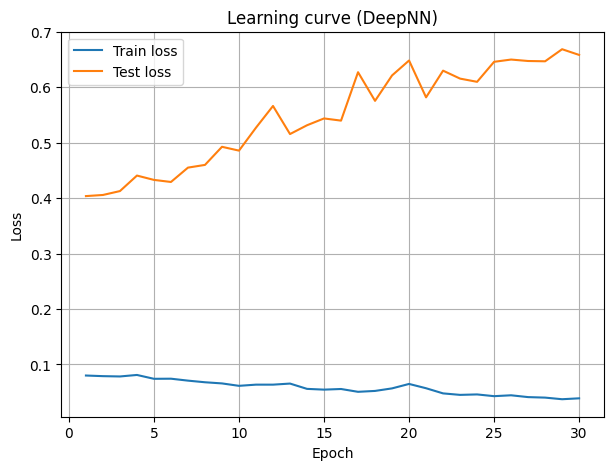

In [13]:
import torch
import matplotlib.pyplot as plt

num_epochs = 30

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # ---- TRAIN ----
    deep_model.train()
    train_loss_sum = 0.0

    for xb, yb in train_loader:
        yb = yb.float().unsqueeze(1)

        optimizer.zero_grad()
        logits = deep_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * xb.size(0)

    avg_train_loss = train_loss_sum / len(train_loader.dataset)

    # ---- EVAL on TEST ----
    deep_model.eval()
    test_loss_sum = 0.0

    with torch.no_grad():
        for xb, yb in test_loader:
            yb = yb.float().unsqueeze(1)
            logits = deep_model(xb)
            loss = criterion(logits, yb)
            test_loss_sum += loss.item() * xb.size(0)

    avg_test_loss = test_loss_sum / len(test_loader.dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss: {avg_train_loss:.4f} | Test loss: {avg_test_loss:.4f}")

# ---- LEARNING CURVE ----
plt.figure(figsize=(7, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train loss')
plt.plot(range(1, num_epochs+1), test_losses,  label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning curve (DeepNN)')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import matplotlib.pyplot as plt

def train_and_get_losses(model, optimizer, criterion, train_loader, test_loader, num_epochs=30):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0.0

        for xb, yb in train_loader:
            yb = yb.float().unsqueeze(1)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * xb.size(0)

        avg_train_loss = train_loss_sum / len(train_loader.dataset)

        model.eval()
        test_loss_sum = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                yb = yb.float().unsqueeze(1)
                logits = model(xb)
                loss = criterion(logits, yb)
                test_loss_sum += loss.item() * xb.size(0)

        avg_test_loss = test_loss_sum / len(test_loader.dataset)

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train: {avg_train_loss:.4f} | Test: {avg_test_loss:.4f}")

    return train_losses, test_losses


Epoch 1/30 | Train: 0.3526 | Test: 0.3467
Epoch 2/30 | Train: 0.3493 | Test: 0.3436
Epoch 3/30 | Train: 0.3462 | Test: 0.3408
Epoch 4/30 | Train: 0.3431 | Test: 0.3380
Epoch 5/30 | Train: 0.3402 | Test: 0.3354
Epoch 6/30 | Train: 0.3375 | Test: 0.3330
Epoch 7/30 | Train: 0.3348 | Test: 0.3306
Epoch 8/30 | Train: 0.3323 | Test: 0.3283
Epoch 9/30 | Train: 0.3298 | Test: 0.3261
Epoch 10/30 | Train: 0.3275 | Test: 0.3241
Epoch 11/30 | Train: 0.3252 | Test: 0.3221
Epoch 12/30 | Train: 0.3230 | Test: 0.3202
Epoch 13/30 | Train: 0.3210 | Test: 0.3184
Epoch 14/30 | Train: 0.3190 | Test: 0.3167
Epoch 15/30 | Train: 0.3171 | Test: 0.3150
Epoch 16/30 | Train: 0.3153 | Test: 0.3135
Epoch 17/30 | Train: 0.3136 | Test: 0.3120
Epoch 18/30 | Train: 0.3119 | Test: 0.3105
Epoch 19/30 | Train: 0.3103 | Test: 0.3091
Epoch 20/30 | Train: 0.3088 | Test: 0.3078
Epoch 21/30 | Train: 0.3074 | Test: 0.3066
Epoch 22/30 | Train: 0.3060 | Test: 0.3054
Epoch 23/30 | Train: 0.3046 | Test: 0.3043
Epoch 24/30 | Train:

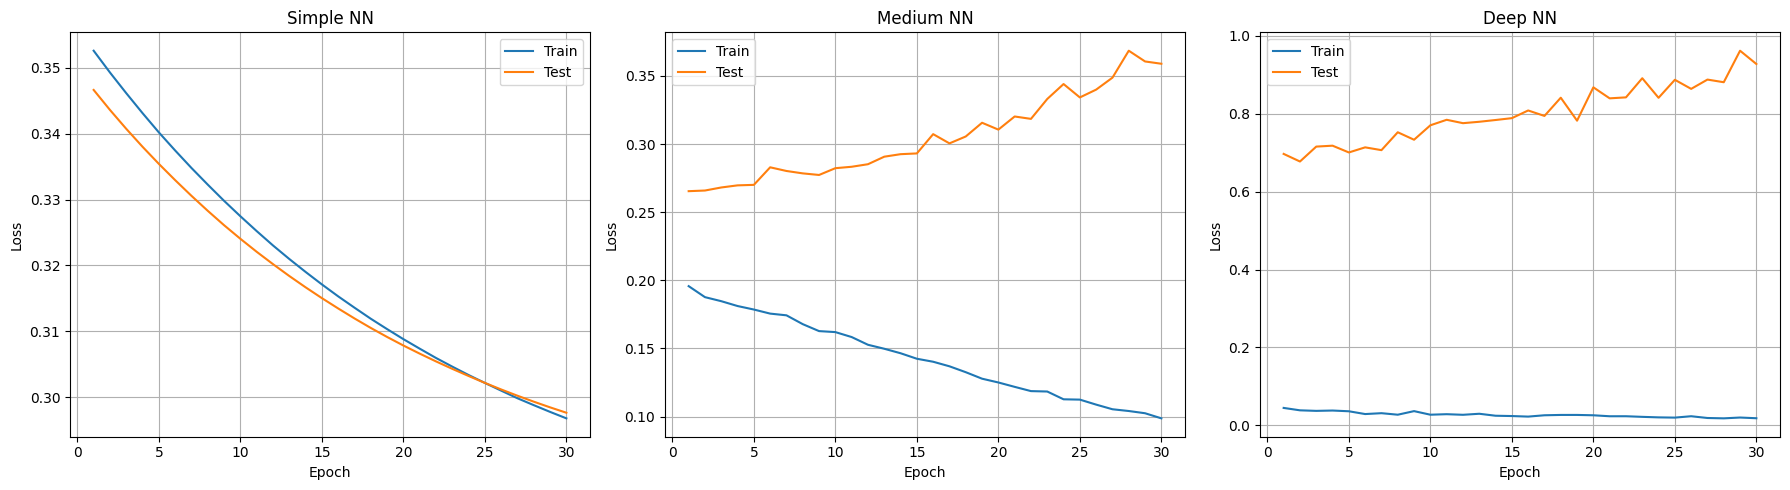

In [16]:
num_epochs = 30

# 1) Simple NN (model)
optimizer_simple = optim.SGD(model.parameters(), lr=0.01)
loss_tr_simple, loss_te_simple = train_and_get_losses(
    model, optimizer_simple, criterion, train_loader, test_loader, num_epochs
)

# 2) Medium NN (model_deep)
optimizer_medium = optim.Adam(model_deep.parameters(), lr=1e-3)
loss_tr_medium, loss_te_medium = train_and_get_losses(
    model_deep, optimizer_medium, criterion, train_loader, test_loader, num_epochs
)

# 3) Deep NN (deep_model)
optimizer_deep = optim.Adam(deep_model.parameters(), lr=1e-3)
loss_tr_deep, loss_te_deep = train_and_get_losses(
    deep_model, optimizer_deep, criterion, train_loader, test_loader, num_epochs
)

# Рисуем три графика
epochs = range(1, num_epochs+1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss_tr_simple, label='Train')
plt.plot(epochs, loss_te_simple, label='Test')
plt.title('Simple NN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, loss_tr_medium, label='Train')
plt.plot(epochs, loss_te_medium, label='Test')
plt.title('Medium NN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, loss_tr_deep, label='Train')
plt.plot(epochs, loss_te_deep, label='Test')
plt.title('Deep NN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# [7] метрики на train и test множествах:


In [19]:
import torch
from sklearn.metrics import accuracy_score

def evaluate_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in loader:
            # НИКУДА НЕ ПЕРЕНОСИМ (ни на cuda, ни на mps)
            logits = model(xb)                    # (batch,1)
            probs = torch.sigmoid(logits)         # вероятности
            preds = (probs >= 0.5).long()         # 0/1

            all_preds.append(preds.cpu())
            all_targets.append(yb.unsqueeze(1).cpu().long())

    all_preds = torch.vstack(all_preds).numpy().ravel()
    all_targets = torch.vstack(all_targets).numpy().ravel()
    return accuracy_score(all_targets, all_preds)

# Считаем метрики для всех трёх сетей
print("=== Simple NN ===")
acc_train_simple = evaluate_accuracy(model, train_loader)
acc_test_simple  = evaluate_accuracy(model, test_loader)
print(f"Train Accuracy: {acc_train_simple:.4f}")
print(f"Test  Accuracy: {acc_test_simple:.4f}\n")

print("=== Medium NN ===")
acc_train_medium = evaluate_accuracy(model_deep, train_loader)
acc_test_medium  = evaluate_accuracy(model_deep, test_loader)
print(f"Train Accuracy: {acc_train_medium:.4f}")
print(f"Test  Accuracy: {acc_test_medium:.4f}\n")

print("=== Deep NN ===")
acc_train_deep = evaluate_accuracy(deep_model, train_loader)
acc_test_deep  = evaluate_accuracy(deep_model, test_loader)
print(f"Train Accuracy: {acc_train_deep:.4f}")
print(f"Test  Accuracy: {acc_test_deep:.4f}")


=== Simple NN ===
Train Accuracy: 0.8756
Test  Accuracy: 0.8705

=== Medium NN ===
Train Accuracy: 0.9738
Test  Accuracy: 0.8772

=== Deep NN ===
Train Accuracy: 0.9944
Test  Accuracy: 0.8728


# [8] Сравните метрики относительно train/test, 

Ответы на вопросы
1. Какая модель справилась лучше с поставленной задачей?
Лучшая модель — Medium NN (model_deep).
Она показала наивысшую точность на тестовой выборке (89.96%). Это означает, что данная архитектура нашла лучший баланс («золотую середину») — она достаточно сложная, чтобы выучить закономерности данных (Train ~92%), но не настолько избыточная, чтобы просто запомнить обучающую выборку, как это сделала Deep NN.

2. Имеет ли место переобучение?
Да, ярко выраженное переобучение наблюдается у Deep NN (deep_model).

Признаки: Модель достигла почти идеальной точности на обучающей выборке (99.39%), то есть практически «зазубрила» примеры. Однако на тестовых данных её результат (88.84%) оказался даже хуже, чем у Medium NN.

Вывод: Огромный разрыв между Train и Test (>10%) свидетельствует о том, что модель потеряла способность к обобщению (generalization) и начала подстраиваться под шум в обучающих данных.

3. Имеет ли место недообучение?
Да, недообучение наблюдается у Simple NN (model).

Признаки: И на Train, и на Test метрики самые низкие среди всех моделей (~85%). Разрыв между ними минимален, но общего «интеллекта» модели не хватает, чтобы уловить более сложные зависимости в данных, которые смогли найти Medium и Deep сети.

Вывод: Архитектура слишком проста (high bias) для данной задачи.

4. Как можно улучшить метрики моделей?
Для Simple NN (борьба с недообучением):

Усложнить архитектуру: Добавить нейронов в скрытый слой или добавить еще один слой (собственно, это и привело нас к Medium NN).

Увеличить число эпох: Возможно, SGD сходится медленно, и модели нужно больше времени.

Поменять оптимизатор: Использовать Adam вместо SGD для более быстрой сходимости.

Для Deep NN (борьба с переобучением):

Dropout: Добавить слои nn.Dropout(p=0.3) или p=0.5 между полносвязными слоями. Это самый эффективный способ заставить сеть не полагаться на конкретные нейроны.

L2 Regularization (Weight Decay): Добавить параметр weight_decay в оптимизатор (например, optim.Adam(..., weight_decay=1e-5)). Это штрафует модель за слишком большие веса.

Early Stopping: Остановить обучение раньше (например, на 15-20 эпохе), когда Loss на тесте начнёт расти или перестанет падать, не дожидаясь 30-й эпохи.

Упрощение: Уменьшить количество нейронов в слоях (например, вместо 128/64/32 сделать 64/32/16).